# 模型评估

假如我们有一个带标签的数据集D，我们如何选择最优的模型？ 

衡量模型好坏的标准是看这个模型在新的数据集上面表现的如何，也就是看它的泛化误差。

因为实际的数据没有标签，所以泛化误差是不可能直接得到的。

于是我们需要在数据集D上面划分出来一小部分数据测试D的性能，用它来近似代替泛化误差。

有三种方法可以进行上面的划分操作：留出法、交叉验证法、自助法。

## 内容概要¶

    训练集/测试集分割用于模型验证的缺点
    K折交叉验证是如何克服之前的不足
    交叉验证如何用于选择调节参数、选择模型、选择特征
    改善交叉验证

## 留出法


  留出法的想法很简单，将原始数据直接划分为互斥的两类，其中一部分用来训练模型，另外一部分用来测试。前者就是训练集，后者就是测试集。

  在sklearn当中，使用train_test_split可以将数据分为训练集和测试集

In [20]:
from sklearn.datasets import load_iris # iris数据集
from sklearn.model_selection import train_test_split # 分割数据模块
from sklearn.neighbors import KNeighborsClassifier # K最近邻(kNN，k-NearestNeighbor)分类算法
import warnings
warnings.filterwarnings("ignore")
# 加载iris数据集
iris = load_iris()
X = iris.data
y = iris.target

#对数据集进行快速打乱（分为训练集和测试集）
# 对数据集进行了shuffle后按照给定的test_size 进行数据集划分
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)

#建立模型
knn = KNeighborsClassifier()

#训练模型
knn.fit(X_train, y_train)

#将准确率打印出
print(knn.score(X_test, y_test))
# 0.973684210526


0.9736842105263158


可以看到基础验证的准确率为0.973684210526

In [3]:
from sklearn.metrics import accuracy_score
y_pred = knn.predict(X_test)
accuracy_score(y_test, y_pred)

0.9736842105263158

留出法非常的简单。但是存在一些问题，比如有些模型还需要进行超参数评估，这个时候还需要划分一类数据集，叫做验证集。

最后数据集的划分划分变成了这样：训练集，验证集还有测试集。 训练集是为了进行模型的训练，验证集是为了进行参数的调整，测试集是为了看这个模型的好坏。

  但是，上面的划分依然有问题，划分出来验证集还有测试集，那么我们的训练集会变小。并且还有一个问题，那就是我们的模型会随着我们选择的训练集和验证集不同而不同。所以这个时候，我们引入了交叉验证（cross-validation 简称cv）

## 交叉验证

Sklearn 中的 Cross Validation (交叉验证)对于我们选择正确的 Model 和 Model 的参数是非常有帮助的， 有了他的帮助，我们能直观的看出不同 Model 或者参数对结构准确度的影响。

进行模型验证的一个重要目的是要选出一个最合适的模型，对于监督学习而言，我们希望模型对于未知数据的泛化能力强，所以就需要模型验证这一过程来体现不同的模型对于未知数据的表现效果。

最先我们用训练准确度（用全部数据进行训练和测试）来衡量模型的表现，这种方法会导致模型过拟合；为了解决这一问题，我们将所有数据分成训练集和测试集两部分，我们用训练集进行模型训练，得到的模型再用测试集来衡量模型的预测表现能力，这种度量方式叫测试准确度，这种方式可以有效避免过拟合。

测试准确度的一个缺点是其样本准确度是一个高方差估计（high variance estimate），所以该样本准确度会依赖不同的测试集，其表现效果不尽相同。

###  高方差估计的例子

还是使用iris数据来说明利用测试准确度来衡量模型表现的方差很高

In [4]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# read in the iris data
iris = load_iris()

X = iris.data
y = iris.target

for i in range(1,10):
    print("random_state is ", i,", and accuracy score is:")
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i)

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    print(metrics.accuracy_score(y_test, y_pred))

random_state is  1 , and accuracy score is:
1.0
random_state is  2 , and accuracy score is:
1.0
random_state is  3 , and accuracy score is:
0.9473684210526315
random_state is  4 , and accuracy score is:
0.9736842105263158
random_state is  5 , and accuracy score is:
0.9473684210526315
random_state is  6 , and accuracy score is:
0.9736842105263158
random_state is  7 , and accuracy score is:
0.8947368421052632
random_state is  8 , and accuracy score is:
0.9210526315789473
random_state is  9 , and accuracy score is:
1.0


上面的测试准确率可以看出，不同的训练集、测试集分割的方法导致其准确率不同.

### Model 交叉验证法(cross_val_score)

在构建模型时，调参是极为重要的一个步骤，因为只有选择最佳的参数才能构建一个最优的模型。但是应该如何确定参数的值呢？

    1、通过经常使用某个模型的经验和高超的数学知识。

    2、通过交叉验证的方法，逐个来验证。

交叉验证的基本思想是：将数据集进行一系列分割，生成一组不同的训练测试集，然后分别训练模型并计算测试准确率，最后对结果进行平均处理。这样来有效降低测试准确率的差异。

<img src="cross_validation_diagram.png">

简单说下，比如上面，我们将数据集分为5折，做一次交叉验证，实际上它是计算了5次，将每一折都当做一次测试集，其余四折当做训练集，这样循环五次。通过传入的模型，训练五次，最后将五次结果求平均值。

交叉验证优点：

    1：交叉验证用于评估模型的预测性能，尤其是训练好的模型在新数据上的表现，可以在一定程度上减小过拟合。
    2：还可以从有限的数据中获取尽可能多的有效信息。

如何利用它来选择参数呢？

    可以给它加上循环，通过循环不断的改变参数，再利用交叉验证来评估不同参数模型的能力。最终选择能力最优的模型。


In [2]:
from sklearn.model_selection import cross_val_score # K折交叉验证模块
??cross_val_score

In [6]:
#使用K折交叉验证模块
#对数据集进行指定次数的交叉验证并为每次验证效果评测
# cv  默认使用KFold 或StratifiedKFold 进行数据集打乱
scores = cross_val_score(knn, X, y, scoring='accuracy', cv=10)

#将5次的预测准确率打印出
print(scores)
# [ 0.96666667  1.          0.93333333  0.96666667  1.        ]

#将5次的预测准确平均率打印出
print(scores.mean())
# 0.973333333333

[1.         0.93333333 1.         1.         0.86666667 0.93333333
 0.93333333 1.         1.         1.        ]
0.9666666666666668


可以看到交叉验证的准确平均率为0.973333333333

其中，scoring 默认是以 scoring='f1_macro'进行评测的，余外针对分类或回归还有：

<img src='score.png'>

除使用默认交叉验证方式外，可以对交叉验证方式进行指定，如验证次数，训练集测试集划分比例等

sklearn.model_selection.ShuffleSplit类用于将样本集合随机“打散”后划分为训练集、测试集

    sklearn.model_selection.ShuffleSplit(
        n_splits=10, test_size=’default’, 
        train_size=None, random_state=None)
        
参数：

- n_splits:int, 划分训练集、测试集的次数，默认为10
- test_size:float, int, None, default=0.1； 测试集比例或样本数量，该值为[0.0, 1.0]内的浮点数时，表示测试集占总样本的比例；该值为整型值时，表示具体的测试集样本数量；train_size不设定具体数值时，该值取默认值0.1，train_size设定具体数值时，test_size取剩余部分
- train_size:float, int, None； 训练集比例或样本数量，该值为[0.0, 1.0]内的浮点数时，表示训练集占总样本的比例；该值为整型值时，表示具体的训练集样本数量；该值为None(默认值)时，训练集取总体样本除去测试集的部分
- random_state:int, RandomState instance or None；随机种子值，默认为None

        

In [7]:
from sklearn.model_selection import ShuffleSplit
n_samples = iris.data.shape[0]
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
cross_val_score(knn, iris.data, iris.target, cv=cv)

array([0.97777778, 0.95555556, 0.95555556, 0.93333333, 0.97777778])

**总结交叉验证步骤**

    1、将数据集平均分割成K个等份
    2、使用1份数据作为测试数据，其余作为训练数据
    3、计算测试准确率
    4、使用不同的测试集，重复2、3步骤
    5、对测试准确率做平均，作为对未知数据预测准确率的估计

##  cross_val_predict

cross_val_predict 与cross_val_score 很相像，不过不同于返回的是评测效果，

cross_val_predict 返回的是estimator 的分类结果（或回归值），这个对于后期模型的改善很重要，可以通过该预测输出对比实际目标值，准确定位到预测出错的地方，为我们参数优化及问题排查十分的重要。


In [5]:
from sklearn.model_selection import cross_val_predict

from sklearn import metrics

predicted = cross_val_predict(knn, iris.data, iris.target, cv=10)

predicted

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [6]:
metrics.accuracy_score(iris.target, predicted)

0.9666666666666667

## KFold

K折交叉验证，这是将数据集分成K份的官方给定方案，所谓K折就是将数据集通过K次分割，使得所有数据既在训练集出现过，又在测试集出现过，当然，每次分割中不会有重叠。相当于无放回抽样。

In [8]:
from sklearn.model_selection import KFold
import numpy as np

In [12]:
X = ['a','b','c','d','e']
kf = KFold(n_splits=2) # 分成两份 数据集+测试集
kf.split(X)
for train, test in kf.split(X):
    print(train, test)
    print(np.array(X)[train], np.array(X)[test])

[3 4] [0 1 2]
['d' 'e'] ['a' 'b' 'c']
[0 1 2] [3 4]
['a' 'b' 'c'] ['d' 'e']


In [15]:
from sklearn.model_selection import KFold
import numpy as np

X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4])

kf = KFold(n_splits=2)
for train_index, test_index in kf.split(X):
    print('train_index', train_index, 'test_index', test_index)
    train_X, train_y = X[train_index], y[train_index]
    test_X, test_y = X[test_index], y[test_index]

train_index [2 3] test_index [0 1]
train_index [0 1] test_index [2 3]


## LeaveOneOut
LeaveOneOut 其实就是KFold 的一个特例，因为使用次数比较多，因此独立的定义出来，完全可以通过KFold 实现。

In [12]:
from sklearn.model_selection import LeaveOneOut

X = [1,2,3,4]

loo = LeaveOneOut()

for train, test in loo.split(X):
    print(train, test)


[1 2 3] [0]
[0 2 3] [1]
[0 1 3] [2]
[0 1 2] [3]


In [13]:
#使用KFold实现LeaveOneOtut
kf = KFold(n_splits=len(X))

for train, test in kf.split(X):
    print(train, test)

[1 2 3] [0]
[0 2 3] [1]
[0 1 3] [2]
[0 1 2] [3]


## LeavePOut

这个也是KFold 的一个特例，用KFold 实现起来稍麻烦些，跟LeaveOneOut 也很像。

In [14]:
from sklearn.model_selection import LeavePOut

X = np.ones(4)

lpo = LeavePOut(p=2)

for train, test in lpo.split(X):
    print(train, test)

[2 3] [0 1]
[1 3] [0 2]
[1 2] [0 3]
[0 3] [1 2]
[0 2] [1 3]
[0 1] [2 3]


## ShuffleSplit
ShuffleSplit 咋一看用法跟LeavePOut 很像，其实两者完全不一样，LeavePOut 是使得数据集经过数次分割后，所有的测试集出现的元素的集合即是完整的数据集，即无放回的抽样，而ShuffleSplit 则是有放回的抽样，只能说经过一个足够大的抽样次数后，保证测试集出现了完成的数据集的倍数。


In [17]:
from sklearn.model_selection import ShuffleSplit

X = np.arange(5)

ss = ShuffleSplit(n_splits=3, test_size=.25, random_state=0)

for train_index, test_index in ss.split(X):
    print(train_index, test_index)


[1 3 4] [2 0]
[1 4 3] [0 2]
[4 0 2] [1 3]


## StratifiedKFold

这个就比较好玩了，通过指定分组，对测试集进行无放回抽样。

In [18]:
from sklearn.model_selection import StratifiedKFold

X = np.ones(10)

y = [0,0,0,0,1,1,1,1,1,1]

skf = StratifiedKFold(n_splits=3)

for train, test in skf.split(X,y):
    print(train, test)


[2 3 6 7 8 9] [0 1 4 5]
[0 1 3 4 5 8 9] [2 6 7]
[0 1 2 4 5 6 7] [3 8 9]


[sklearn中的交叉验证](https://blog.csdn.net/xiaodongxiexie/article/details/71915259)

# 调节参数与评价指标

## 以准确率(accuracy)判断

一般来说准确率(accuracy)会用于判断分类(Classification)模型的好坏。

交叉验证的方法可以帮助我们进行调参，最终得到一组最佳的模型参数。

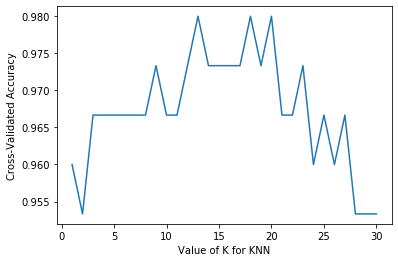

In [17]:
import matplotlib.pyplot as plt #可视化模块
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris # iris数据集
from sklearn.model_selection import train_test_split # 分割数据模块
from sklearn.neighbors import KNeighborsClassifier # K最近邻(kNN，k-NearestNeighbor)分类算法
%matplotlib inline


#加载iris数据集
iris = load_iris()
X = iris.data
y = iris.target
#建立KNN测试参数
k_range = range(1, 31)

k_scores = []  #用来放每个模型的结果值

#藉由迭代的方式来计算不同参数对模型的影响，并返回交叉验证后的平均准确率
for k in k_range:
    # knn模型，这里一个超参数可以做预测，当多个超参数时需要使用另一种方法GridSearchCV
    knn = KNeighborsClassifier(n_neighbors=k)
    # 这里的cross_val_score将交叉验证的整个过程连接起来，不用再进行手动的分割数据
    # cv参数用于规定将原始数据分成多少份
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())

#可视化数据
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

从图中可以得知，选择12~18的k值最好。高过18之后，准确率开始下降则是因为过拟合(Over fitting)的问题。

上面的例子显示了偏置-方差的折中，K较小的情况时偏置较低，方差较高；K较高的情况时，偏置较高，方差较低；最佳的模型参数取在中间位置，该情况下，使得偏置和方差得以平衡，模型针对于非样本数据的泛化能力是最佳的。

再优化一下代码，把数据集分成训练集和测试集

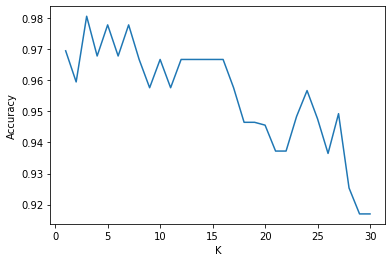

In [18]:
from sklearn import datasets	#自带数据集
from sklearn.model_selection import train_test_split,cross_val_score	#划分数据 交叉验证
from sklearn.neighbors import KNeighborsClassifier  #一个简单的模型，只有K一个参数，类似K-means
import matplotlib.pyplot as plt
iris = datasets.load_iris()		#加载sklearn自带的数据集
X = iris.data 			#这是数据
y = iris.target 		#这是每个数据所对应的标签

train_X,test_X,train_y,test_y = train_test_split(X,y,test_size=1/3,random_state=3)	#这里划分数据以1/3的来划分 训练集训练结果 测试集测试结果

k_range = range(1,31)
cv_scores = []		#用来放每个模型的结果值
for n in k_range:
    knn = KNeighborsClassifier(n)   #knn模型，这里一个超参数可以做预测，当多个超参数时需要使用另一种方法GridSearchCV
    scores = cross_val_score(knn,train_X,train_y,cv=10,scoring='accuracy')  #cv：选择每次测试折数  accuracy：评价指标是准确度,可以省略使用默认值
    cv_scores.append(scores.mean())
plt.plot(k_range,cv_scores)
plt.xlabel('K')
plt.ylabel('Accuracy')		#通过图像选择最好的参数
plt.show()


In [19]:
# 选择最优的K=3传入模型
knn = KNeighborsClassifier(3)
#训练模型
knn.fit(train_X, train_y)
#看看评分
knn.score(test_X, test_y)

0.94

## 以平均方差(Mean squared error)

一般来说平均方差(Mean squared error)会用于判断回归(Regression)模型的好坏。

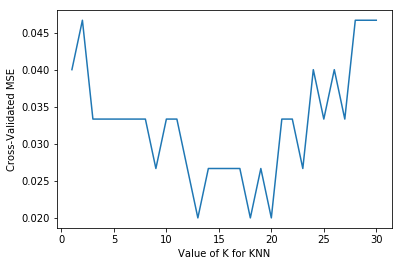

In [22]:
 多方沟进去1import matplotlib.pyplot as plt
k_range = range(1, 31)
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    #loss = -cross_val_score(knn, X, y, cv=10, scoring='mean_squared_error')
    loss = -cross_val_score(knn, X, y, cv=10, scoring='neg_mean_squared_error')
    k_scores.append(loss.mean())

plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated MSE')
plt.show()

由图可以得知，平均方差越低越好，因此选择13~18左右的K值会最好。

# 用于模型选择

交叉验证也可以帮助我们进行模型选择，以下是一组例子，分别使用iris数据，KNN和logistic回归模型进行模型的比较和选择。

In [20]:
# 10-fold cross-validation with the best KNN model
knn = KNeighborsClassifier(n_neighbors=20)
print(cross_val_score(knn, X, y, cv=10, scoring='accuracy').mean())

0.9800000000000001


In [21]:
# 10-fold cross-validation with logistic regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
print(cross_val_score(logreg, X, y, cv=10, scoring='accuracy').mean())

0.9533333333333334


D:\Program Files (x86)\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Program Files (x86)\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
D:\Program Files (x86)\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Program Files (x86)\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
D:\Program Files (x86)\Anaconda3\lib\site-packages\sklearn\linear_model\lo

In [22]:
def model_compare(classifiers, cv=10, scr='accuracy'):
    all_scores = []
    for name, clf in classifiers.items():
        scores = cross_val_score(clf, X, y, cv=cv, scoring=scr)
        print(name,'\t--> ',scores.mean())
        all_scores.append(scores.mean())
    return all_scores

In [23]:
classifiers = {
'KN': KNeighborsClassifier(3),
'LR': LogisticRegression()
}

In [24]:
ascores = model_compare(classifiers)

KN 	-->  0.9666666666666666
LR 	-->  0.9533333333333334


D:\Program Files (x86)\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Program Files (x86)\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
D:\Program Files (x86)\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Program Files (x86)\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
D:\Program Files (x86)\Anaconda3\lib\site-packages\sklearn\linear_model\lo

In [25]:
index = list(classifiers.keys())

In [26]:
values = ascores

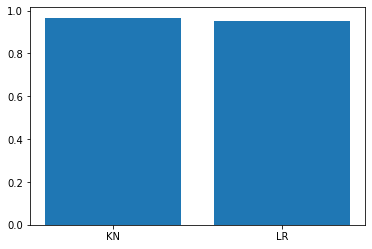

In [27]:
plt.figure()
plt.bar(index, values)
plt.show()

# 用于特征选择

下面我们使用advertising数据，通过交叉验证来进行特征的选择，对比不同的特征组合对于模型的预测效果。

In [28]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# read in the advertising dataset
data = pd.read_csv('Advertising.csv', index_col=0)

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
TV           200 non-null float64
radio        200 non-null float64
newspaper    200 non-null float64
sales        200 non-null float64
dtypes: float64(4)
memory usage: 7.8 KB


构建特征向量

In [33]:
# create a Python list of three feature names
feature_cols = ['TV', 'radio', 'newspaper']

# use the list to select a subset of the DataFrame (X)
X = data[feature_cols]

# select the Sales column as the response (y)
y = data.sales

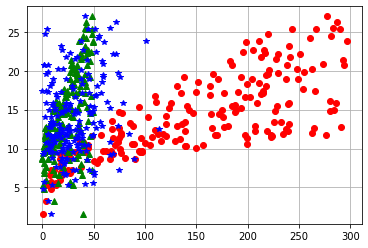

In [34]:
# 绘制1
plt.plot(data['TV'], y, 'ro', label='TV')
plt.plot(data['radio'], y, 'g^', label='radio')
plt.plot(data['newspaper'], y, 'b*', label='newspaer') # plt.legend(loc='lower right')
plt.grid()
plt.show()

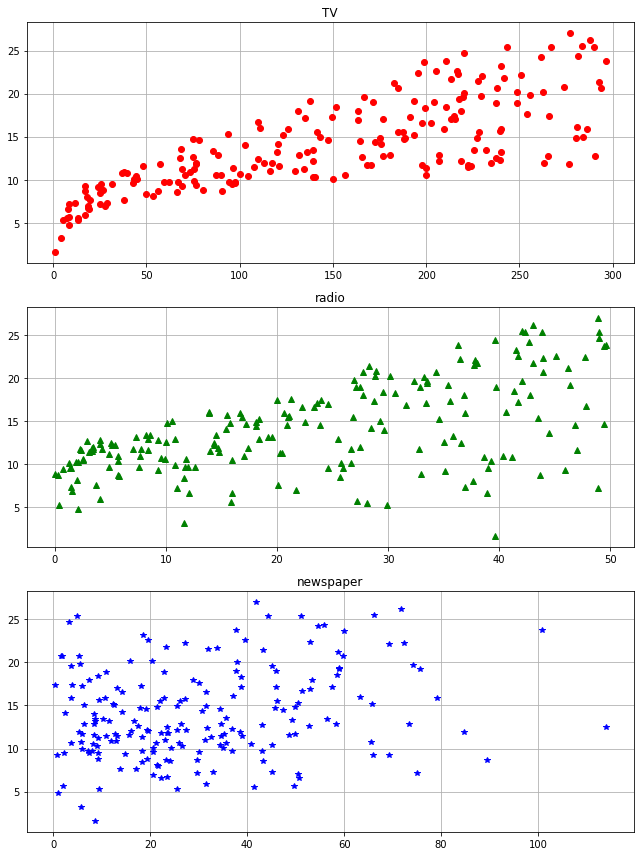

In [35]:
plt.figure(figsize=(9,12)) 
plt.subplot(311) 
plt.plot(data['TV'], y, 'ro') 
plt.title('TV')
plt.grid()
plt.subplot(312) 
plt.plot(data['radio'], y, 'g^') 
plt.title('radio')
plt.grid()
plt.subplot(313) 
plt.plot(data['newspaper'], y, 'b*') 
plt.title('newspaper')
plt.grid()
plt.tight_layout()
plt.show()

## 使用自留法进行特征选择

In [61]:
#训练集 与 测试集
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(150, 3) (50, 3) (150,) (50,)


In [62]:
#根据图目测貌似有线性相关性
from sklearn.linear_model import LinearRegression
linereg=LinearRegression()
model=linereg.fit(X_train,y_train)

In [63]:
linereg.intercept_

2.8769666223179318

In [64]:
linereg.coef_

array([0.04656457, 0.17915812, 0.00345046])

In [65]:
zip(feature_cols,linereg.coef_)

In [67]:
for x in zip(feature_cols,linereg.coef_):
    print(x)

('TV', 0.046564567874150295)
('radio', 0.1791581224508883)
('newspaper', 0.0034504647111804065)


In [68]:
y_predict=linereg.predict(X_test)

In [72]:
y_predict[:5]

array([21.70910292, 16.41055243,  7.60955058, 17.80769552, 18.6146359 ])

In [71]:
y_test[:5]

59     23.8
41     16.6
35      9.5
103    14.8
185    17.6
Name: sales, dtype: float64

In [73]:
from sklearn.metrics import mean_squared_error

In [74]:
mean_squared_error(y_test, y_predict)

1.9730456202283397

In [76]:
# MES
def mse(y_test, y_true):
    return np.mean((y_test - y_true) ** 2)

In [77]:
mse(y_test, y_predict)

1.9730456202283393

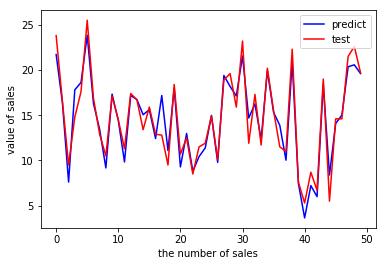

In [80]:
plt.plot(range(len(y_predict)),y_predict,'b',label="predict")
plt.plot(range(len(y_predict)),y_test,'r',label="test")
plt.legend(loc="upper right")
plt.xlabel("the number of sales")
plt.ylabel('value of sales')
plt.show()

根据目测Newspaper 与sales的多少并没有什么联系同时最后的参数('Newspaper', 0.0034504647111804204)] 也是及其小

因此可以尝试移除Newspaper这个特征值

In [81]:
x=data[['TV','radio']]

In [83]:
X_train,X_test, y_train, y_test = train_test_split(x, y, random_state=1)
linereg=LinearRegression()
model=linereg.fit(X_train,y_train)

In [84]:
model.intercept_

2.9272373202664816

In [85]:
model.coef_

array([0.04660234, 0.18117959])

In [86]:
y_predict=linereg.predict(X_test)

In [88]:
model.score(X_test, y_test)

0.9176214942248907

In [89]:
mean_squared_error(y_test, y_predict)

1.9262760418667428

In [90]:
# RMSE
def rmse(y_test, y_true):
    return np.sqrt(np.mean((y_test - y_true) ** 2))

In [91]:
rmse(y_test, y_predict)

1.3879034699382888

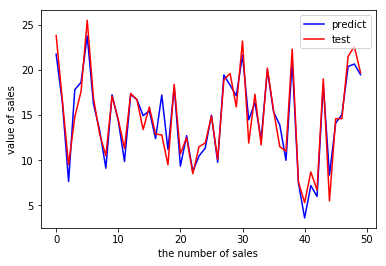

In [92]:
plt.plot(range(len(y_predict)),y_predict,'b',label="predict")
plt.plot(range(len(y_predict)),y_test,'r',label="test")
plt.legend(loc="upper right")
plt.xlabel("the number of sales")
plt.ylabel('value of sales')
plt.show()

总结

'''
我们在将 Newspaper 这个特征移除之后,得到 RMSE 变小了,
说明 Newspaper 特征可能不适合作为预测销量的特征,于是,我们得到了新的模型。
我们还可以通过不同的特
征组合得到新的模型,看看最终的误差是如何的。
在机器学习中有“奥卡姆剃刀”的原理,即:如果能够用简单模型解决问题, 则不使用更为复杂的模型。
因为复杂模型往往增加了不确定性,造成过多的人力 和物力成本,且容易过拟合。

## 使用交叉验证方式进行特征选择

In [94]:
# 10-fold cv with all features
lm = LinearRegression()
scores = cross_val_score(lm, X, y, cv=10, scoring='neg_mean_squared_error')  # scoring='mean_squared_error'
print(scores)

[-3.56038438 -3.29767522 -2.08943356 -2.82474283 -1.3027754  -1.74163618
 -8.17338214 -2.11409746 -3.04273109 -2.45281793]


这里要注意的是，上面的scores都是负数，为什么均方误差会出现负数的情况呢？因为这里的mean_squared_error是一种损失函数，优化的目标的使其最小化，而分类准确率是一种奖励函数，优化的目标是使其最大化。

In [95]:
# fix the sign of MSE scores
mse_scores = -scores
print(mse_scores)


[3.56038438 3.29767522 2.08943356 2.82474283 1.3027754  1.74163618
 8.17338214 2.11409746 3.04273109 2.45281793]


In [96]:
# convert from MSE to RMSE
rmse_scores = np.sqrt(mse_scores)
print(rmse_scores)

[1.88689808 1.81595022 1.44548731 1.68069713 1.14139187 1.31971064
 2.85891276 1.45399362 1.7443426  1.56614748]


In [97]:
# calculate the average RMSE
print(rmse_scores.mean())

1.6913531708051797


In [98]:
# 10-fold cross-validation with two features (excluding Newspaper)
feature_cols = ['TV', 'radio']
X = data[feature_cols]
print(np.sqrt(-cross_val_score(lm, X, y, cv=10, scoring='neg_mean_squared_error')).mean())

1.6796748419090766


由于不加入newspaper这一个特征得到的分数较小（1.68 < 1.69），所以，使用所有特征得到的模型是一个更好的模型。

# 交叉验证 2 - learning_curve

## 学习曲线是什么

学习曲线是不同训练集大小，模型在训练集和验证集上的得分变化曲线。也就是以样本数为横坐标，训练和交叉验证集上的得分（如准确率）为纵坐标。learning curve可以很直观的看出我们的 model 学习的进度,帮助我们判断模型现在所处的状态：过拟合（overfiting / high variance） or 欠拟合（underfitting / high bias） ,然后我们可以对我们的 model 进行调整


<img src='learningcurve.png'>

## 怎么看学习曲线
左上角的图中训练集和验证集上的曲线能够收敛。在训练集合验证集上准确率相差不大，却都很差。这说明模拟对已知数据和未知都不能进行准确的预测，属于高偏差。这种情况模型很可能是欠拟合。可以针对欠拟合采取对应的措施。

右上角的图中模型在训练集上和验证集上的准确率差距很大。说明模型能够很好的拟合已知数据，但是泛化能力很差，属于高方差。模拟很可能过拟合，要采取过拟合对应的措施


## Learning curve 检视过拟合

加载对应模块:

In [28]:
# from sklearn.learning_curve import learning_curve #学习曲线模块  将被弃用
from sklearn.model_selection  import learning_curve #学习曲线模块
from sklearn.datasets import load_digits #digits数据集
from sklearn.svm import SVC #Support Vector Classifier
import matplotlib.pyplot as plt #可视化模块
import numpy as np

加载digits数据集，其包含的是手写体的数字，从0到9。数据集总共有1797个样本，每个样本由64个特征组成， 分别为其手写体对应的8×8像素表示，每个特征取值0~16。

In [29]:
digits = load_digits()
X = digits.data
y = digits.target

观察样本由小到大的学习曲线变化, 采用K折交叉验证 cv=10, 选择平均方差检视模型效能 scoring='neg_mean_squared_error', 样本由小到大分成5轮检视学习曲线(10%, 25%, 50%, 75%, 100%):

In [30]:
train_sizes, train_loss, test_loss = learning_curve(
    SVC(gamma=0.001), X, y, cv=10, scoring='neg_mean_squared_error',
    train_sizes=[0.1, 0.25, 0.5, 0.75, 1])

#平均每一轮所得到的平均方差(共5轮，分别为样本10%、25%、50%、75%、100%)
train_loss_mean = -np.mean(train_loss, axis=1)
test_loss_mean = -np.mean(test_loss, axis=1)

可视化图形:

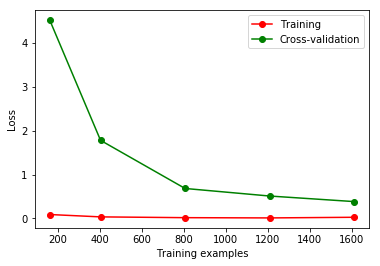

In [31]:
plt.plot(train_sizes, train_loss_mean, 'o-', color="r",
         label="Training")
plt.plot(train_sizes, test_loss_mean, 'o-', color="g",
        label="Cross-validation")

plt.xlabel("Training examples")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()

In [33]:
X.shape

(1797, 64)

官方学习曲线例子


- 1.现将所有样本用交叉验证方法或者（随机抽样方法) 得到 K对 训练集-验证集
- 2.依次对K个训练集，拿出数量不断增加的子集如m个，并在这些K*m个子集上训练模型。
- 3.依次在对应训练集子集、验证集上计算得分。
- 4.对每种大小下的子集，计算K次训练集得分均值和K次验证集得分均值，共得到m对值。
- 5.绘制学习率曲线。x轴训练集样本量，y轴模型得分或预测准确率。

 

用到的方法：

    learning_curve #直接得到1个模型在不同训练集大小参数下：1.训练集大小 2.训练得分 3.测试得分

    ShuffleSplit  #实现交叉验证、或 随机抽样划分不同的训练集合验证集

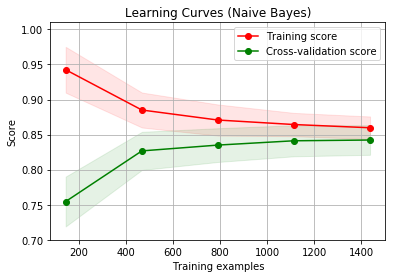

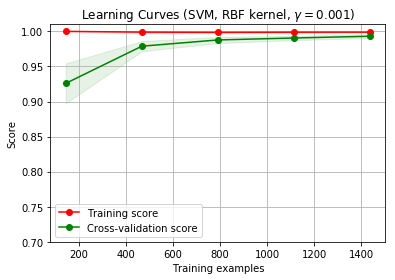

(0.9949213721162846, 0.008853602264398241)

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    画出data在某模型上的learning curve.
    参数解释
    ----------
    estimator : 你用的分类器。
    title : 表格的标题。
    X : 输入的feature，numpy类型
    y : 输入的target vector
    ylim : tuple格式的(ymin, ymax), 设定图像中纵坐标的最低点和最高点
    cv : 做cross-validation的时候，数据分成的份数，其中一份作为cv集，其余n-1份作为training(默认为3份)
    n_jobs : 并行的的任务数(默认1)
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.draw()
    plt.show()

    midpoint = ((train_scores_mean[-1] + train_scores_std[-1]) + (test_scores_mean[-1] - test_scores_std[-1])) / 2
    diff = (train_scores_mean[-1] + train_scores_std[-1]) - (test_scores_mean[-1] - test_scores_std[-1])
    return midpoint, diff


digits = load_digits()
X, y = digits.data, digits.target


title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)

说明：

1. 贝叶斯模型上，训练集规模达到1100时已经比较合适，太小的话会导致过拟合。。总的来看，该模型的准确率趋向于0.85

2. SVM模型上，训练集规模到800时已经比较合适，太小的话会导致训练集无代表性，对验证集无预测能力。。。总的来看，该模型在这份数据上的表现比第一个好。

# 交叉验证 3 - validation_curve

连续三节的交叉验证(cross validation)让我们知道在机器学习中验证是有多么的重要, 这一次的 sklearn 中我们用到了sklearn.model_selectio当中的另外一种, 叫做validation_curve,用这一种曲线我们就能更加直观看出改变模型中的参数的时候有没有过拟合(overfitting)的问题了. 这也是可以让我们更好的选择参数的方法.

validation_curve 检视过拟合

继续上一节的例子，并稍作小修改即可画出图形。这次我们来验证SVC中的一个参数 gamma 在什么范围内能使 model 产生好的结果. 以及过拟合和 gamma 取值的关系.

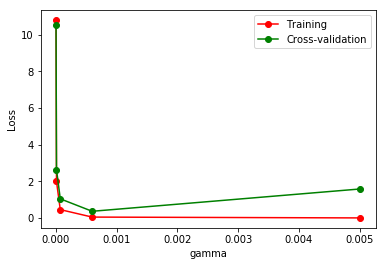

In [34]:
from sklearn.model_selection import validation_curve
#from sklearn.learning_curve import validation_curve #validation_curve模块  将被弃用
from sklearn.datasets import load_digits 
from sklearn.svm import SVC 
import matplotlib.pyplot as plt 
import numpy as np

#digits数据集
digits = load_digits()
X = digits.data
y = digits.target

#建立参数测试集
param_range = np.logspace(-6, -2.3, 5)

#使用validation_curve快速找出参数对模型的影响
train_loss, test_loss = validation_curve(
    SVC(), X, y, param_name='gamma', param_range=param_range, cv=10, scoring='neg_mean_squared_error')

#平均每一轮的平均方差
train_loss_mean = -np.mean(train_loss, axis=1)
test_loss_mean = -np.mean(test_loss, axis=1)

#可视化图形
plt.plot(param_range, train_loss_mean, 'o-', color="r",
         label="Training")
plt.plot(param_range, test_loss_mean, 'o-', color="g",
        label="Cross-validation")

plt.xlabel("gamma")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()

由图中可以明显看到gamma值大于0.001，模型就会有过拟合(Overfitting)的问题。